# Clustering Census Data
**NOTE**: parts of this notebook have been
borrowed from [GDS'17 - Lab
6](http://darribas.org/gds17/content/labs/lab_06.html)
--> and its Texbook Source is: [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)

In [1]:
!pip install esda
!pip install geopandas==0.8.2

In [2]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn 
import pandas
import geopandas 
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

## Introduction


Clustering is a method of data analysis that draws insights
from large, complex multivariate processes.

It works by finding similarities among the many dimensions in a multivariate process, condensing them down into a simpler representation.

Thus, through clustering, we seek to reduce the complexity of the data

Often, clustering involves sorting observations into groups. For these groups to be
meaningful, members of a group should be more similar to one another than they are 
to members of a different group.

Each group is referred to as a *cluster* while the process of assigning
objects to groups is known as *clustering*. 


Since a good cluster is more
similar internally than it is to any other cluster, these cluster-level profiles
provide a convenient shorthand to describe the original complex multivariate process.

Observations in one group may have consistently high 
scores on some traits but low scores on others. 
The analyst only needs to look at the profile of a cluster in order to get a
good sense of what all the observations in that cluster are like, instead of
having to consider all of the complexities of the original multivariate process at once. 
Throughout data science, and particularly in geographic data science, 
clustering is widely used to provide insights on the
geographic structure of complex multivariate spatial data. 

 

We then consider geodemographic approaches to clustering&mdash;the application
of multivariate clustering to spatially referenced demographic data.
Two popular clustering algorithms are employed: k-means method.
Mapping the spatial distribution of the resulting clusters 
reveals interesting insights on the socioeconomic structure of the San Diego
metropolitan area. We also see that in many cases, clusters are spatially 
fragmented. That is, a cluster may actually consist of different areas that are not
spatially connected. Indeed, some clusters will have their members strewn all over the map. 
This will illustrate why connectivity might be important when building insight
about spatial data, since these clusters will not at all provide intelligible regions. 
So, we then will move on to regionalization, exploring different approaches that
incorporate geographical constraints into the exploration of the social structure of San Diego.

## Data

The dataset we will use in this chapter comes from the American Community Survey
(ACS). In particular, we examine data at the Census Tract level in San Diego,
California in 2017. Let us begin by reading in the data as a GeoDataFrame and
exploring the attribute names.

In [3]:
# Read file
db = geopandas.read_file('sandiego_tracts.gpkg')
# Print column names
db.columns

Index(['GEOID', 'median_age', 'total_pop', 'total_pop_white', 'tt_work',
       'hh_total', 'hh_female', 'total_bachelor', 'median_hh_income',
       'income_gini', 'total_housing_units', 'total_rented', 'median_no_rooms',
       'median_house_value', 'NAME', 'state', 'county', 'tract', 'area_sqm',
       'pct_rented', 'pct_hh_female', 'pct_bachelor', 'pct_white', 'sub_30',
       'geometry'],
      dtype='object')

In [4]:
db.head()

,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,...,state,county,tract,area_sqm,pct_rented,pct_hh_female,pct_bachelor,pct_white,sub_30,geometry
0,06073018511,35.7,5205.0,3428.0,2552.0,5205.0,678.0,59.0,49506.0,0.3724,...,06,073,018511,1.689368,0.524267,0.130259,0.011335,0.658598,False,"POLYGON ((-13063789.970 3922505.030, -13063789..."
1,06073017701,35.3,5299.0,4937.0,2073.0,5299.0,652.0,11.0,79875.0,0.4639,...,06,073,017701,2.923197,0.392060,0.123042,0.002076,0.931685,False,"POLYGON ((-13059537.230 3907015.040, -13059431..."
2,06073019302,39.4,7836.0,6224.0,3637.0,7836.0,823.0,71.0,53689.0,0.4573,...,06,073,019302,2.496942,0.458140,0.105028,0.009061,0.794283,False,"POLYGON ((-13056382.100 3924172.840, -13056362..."
3,06073008006,34.7,3928.0,3666.0,2385.0,3928.0,415.0,0.0,92253.0,0.4954,...,06,073,008006,1.489584,0.614213,0.105652,0.000000,0.933299,False,"POLYGON ((-13055008.980 3870449.060, -13054968..."
4,06073008003,32.1,4154.0,3549.0,2667.0,4154.0,445.0,51.0,101591.0,0.4358,...,06,073,008003,0.750638,0.667912,0.107126,0.012277,0.854357,False,"POLYGON ((-13053579.300 3869456.240, -13053548..."


To make things easier later on, let us collect the variables we will use to
characterize Census tracts. These variables capture different aspects of the socio-
economic reality of each area and, taken together, they provide a comprehensive
characterization of San Diego as a whole:

In [5]:
cluster_variables =  [
    'median_house_value', # Median house value
    'pct_white',          # Percent of tract population that is white
    'pct_rented',         # Percent of households that are rented
    'pct_hh_female',      # Percent of female-led households 
    'pct_bachelor',       # Percent of tract population with a Bachelors degree
    'median_no_rooms',    # Median number of rooms in the tract's households
    'income_gini',        # Gini index measuring tract wealth inequality
    'median_age',         # Median age of tract population
    'tt_work'             # Travel time to work 
]

In [6]:
cluster_variables

['median_house_value',
 'pct_white',
 'pct_rented',
 'pct_hh_female',
 'pct_bachelor',
 'median_no_rooms',
 'income_gini',
 'median_age',
 'tt_work']

### Exploring the data

Now let's start building up our understanding of this
dataset through both visual and summary statistical measures.

We will start by
looking at the spatial distribution of each variable alone.
Let's use sequential color scheme for the nine attributes and compare these choropleth maps side-by-side:
https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
(Yellow and light means low Red and Dark means High and organge is in the middle)

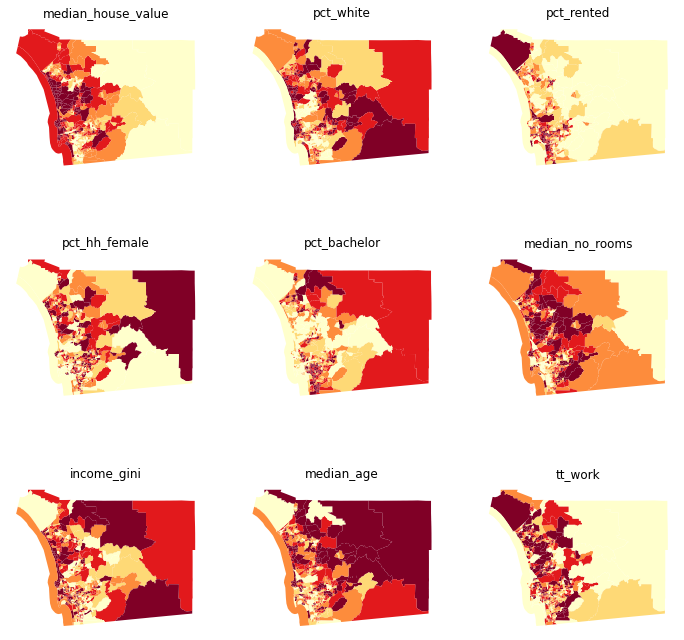

In [7]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='YlOrRd')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Many visual patterns jump out from the maps, revealing both commonalities as
well as differences across the spatial distributions of the individual variables.
Several variables tend to increase in value from the east to the west
(`pct_rented`, `median_house_value`, `median_no_rooms`, and `tt_work`) while others

Some have a spatial trend in the opposite direction (`pct_rented`, `median_no_rooms`).

If all variables display very similar 
spatial patterns, the amount of useful information across the maps is 
actually smaller than it appears, so cluster profiles may be much less useful as well.

It is also important to consider whether the variables display any
spatial autocorrelation, as this will affect the spatial structure of the
resulting clusters. 


First, we need to build a spatial weights matrix that encodes the spatial
relationships in our San Diego data. We will start with queen contiguity:

In [8]:
w = Queen.from_dataframe(db)

As we have seen before, `w` does not contain any islands:

In [9]:
w.islands

[]

Now let's calculate Moran's I for the variables being used. This will measure
the extent to which each variable contains spatial structure:

In [10]:
# Set seed for reproducibility
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(db[variable], w) for variable in cluster_variables]
# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(cluster_variables, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


Each of the variables displays significant positive spatial autocorrelation,
that Tobler's law. This means we also should expect clusters to have
spatial coherence in addition to the coherence in their profiles,
since there is strong positive autocorrelation in all of the input variables.

Let's  consider the
spatial correlation between variables. Here, we will measure this using the
bivariate correlation in the maps of covariates themselves.

Given the 9 maps, there are 36 pairs of maps that must be compared. This is too 
many maps to process visually, so we can turn to an alternative tool to
explicitly focus on the bivariate relations between each pair of attributes.

In [11]:
max(db['median_house_value'])   #Tract with Max Median House Value

2000001.0

In [12]:
min(db['median_house_value'])   #Tract with Min Median House Value Median House Value

17900.0

In [13]:
sum(db['median_house_value'])/len(db['median_house_value']) #Average of Median House Value

515570.8963815788

In [14]:
sum(db['tt_work'])/len(db['tt_work'])/60 #averate tt_work

38.87388535031847

In [15]:
max(db['tt_work'])/60   #max TT work is Six Hours!

402.3833333333333

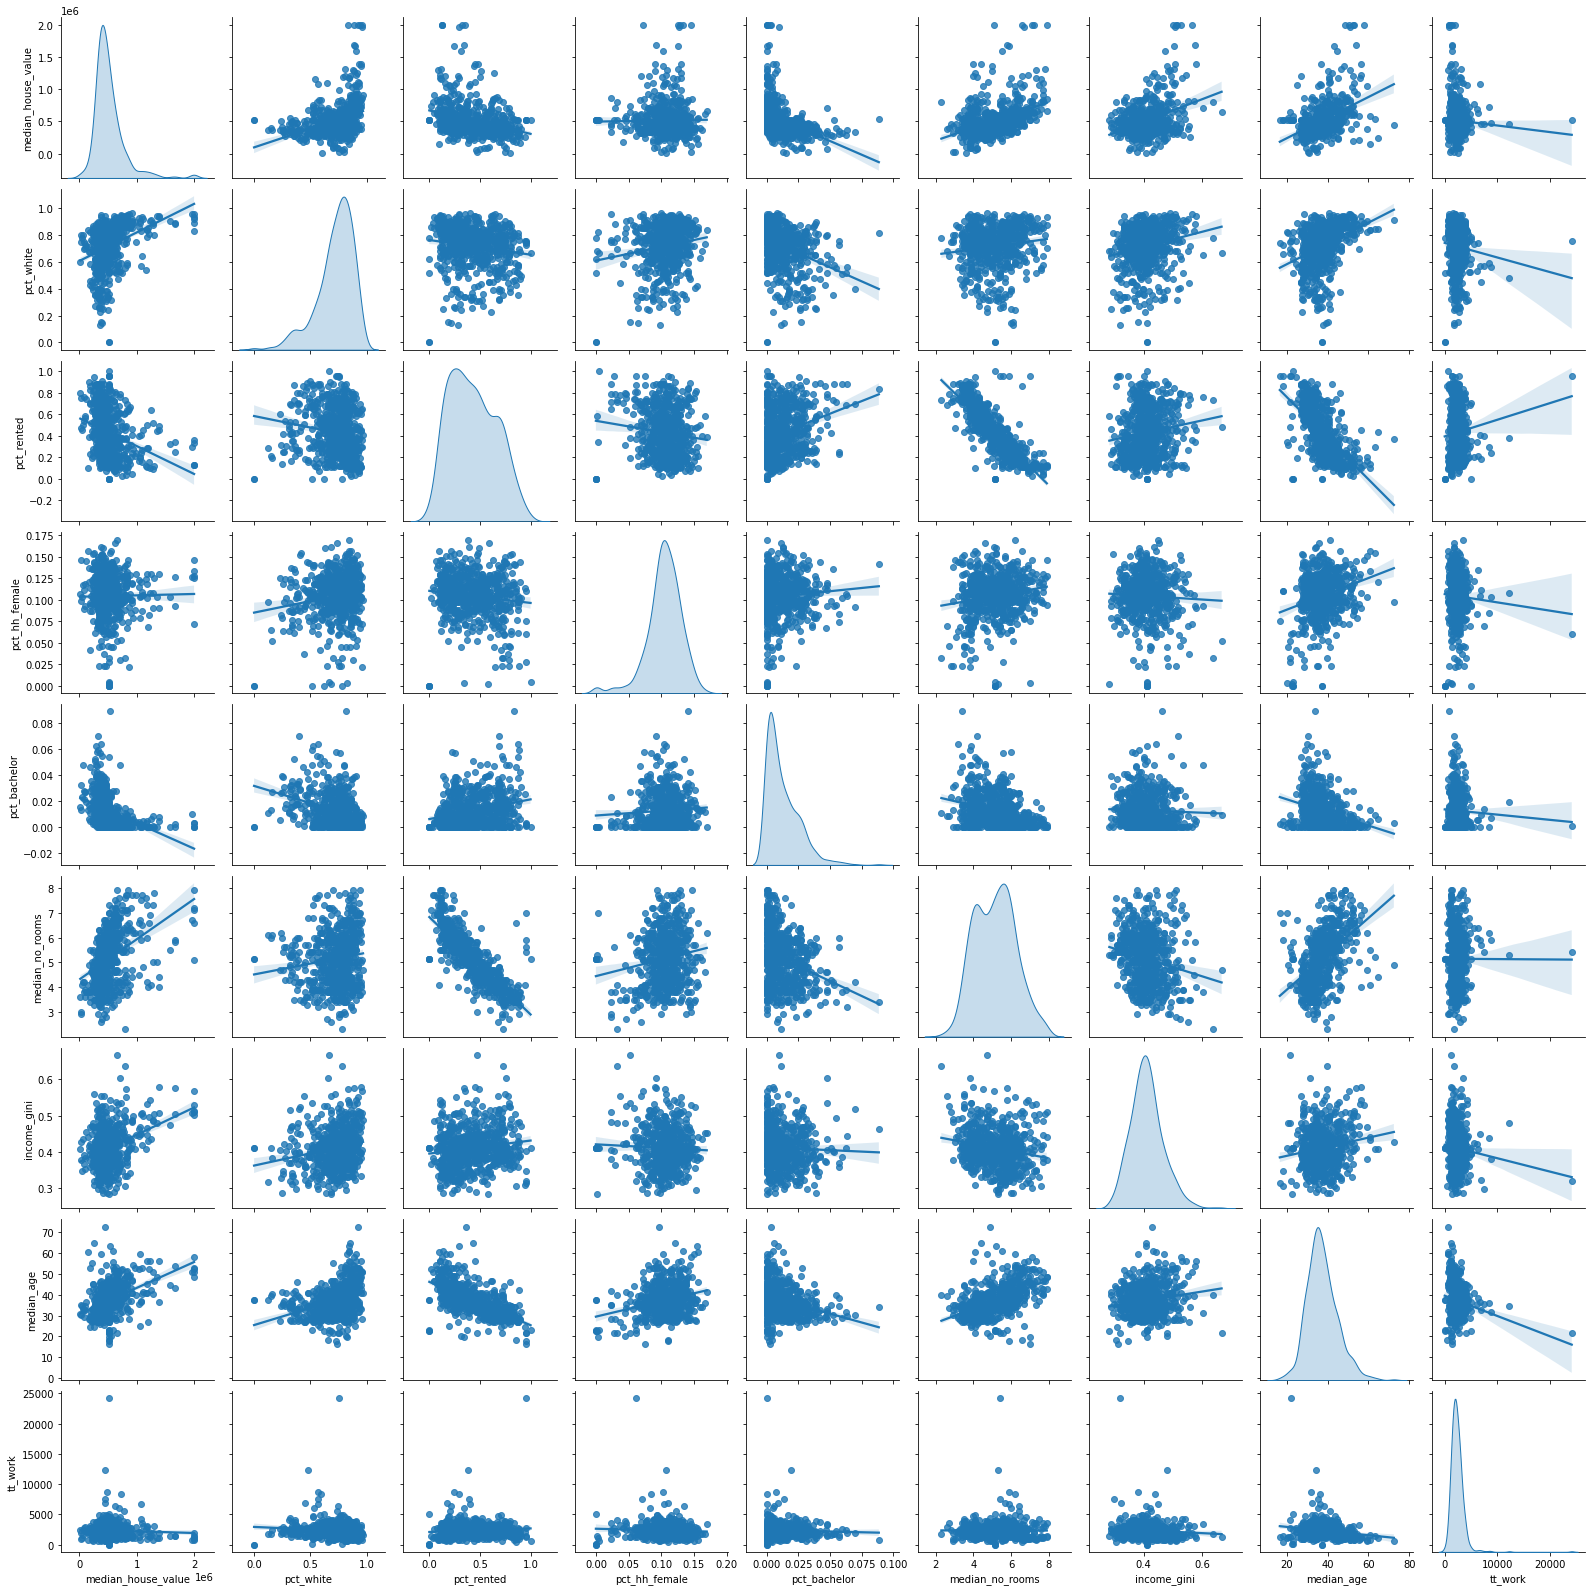

In [16]:
_ = seaborn.pairplot(db[cluster_variables], kind='reg', diag_kind='kde')

Two different types of plots are contained in the scatterplot matrix. On the
diagonal are the density functions for the nine attributes. These allow for an
inspection of the overall morphology of the attribute's value distribution.
Examining these we see that our selection of variables includes those that are
negatively skewed (`pct_white` and `pct_hh_female`) as well as positively skewed
(`median_house_value`, `pct_bachelor`, and `tt_work`).

The second type of visualization lies in the off-diagonal cells of the matrix; 
these are bi-variate scatterplots. Each cell shows the association between one
pair of variables. Several of these cells indicate positive linear
associations (`median_age` Vs. `median_house_value`, `median_house_value` Vs. `median_no_rooms`)
while other cells display negative correlation (`median_house_value` Vs. `pct_rented`,
`median_no_rooms` Vs. `pct_rented`, and `median_age` Vs. `pct_rented`). The one variable
that tends to have consistenty weak association with the other variables is
`tt_work`, and in part this appears to reflect its rather concentrated 
distribution as seen on the lower right diagonal corner cell.

## Geodemographic Clusters in San Diego Census Tracts

We now will move
beyond the implicitly bi-variate focus to consider the full multidimensional
nature of this data set. 

Altogether, these methods use
multivariate clustering algorithms to construct a known number of
clusters ($k$), where the number of clusters is typically smaller than the 
number of observations to be clustered. 

Each cluster is given a unique label,
and these labels are mapped. Using the clusters' profile and label, the map of 
labels can be interpreted to get a sense of the spatial distribution of 
sociodemographic traits. The power of clustering comes
from taking statistical variation across several dimensions and compressing it
into a single categorical one that we can visualize through a map. To
demonstrate the variety of approaches in clustering, we will show a popular
clustering algorithms: k-means.

### K-means

K-means is probably the most widely used approach to
cluster a dataset. The algorithm groups observations into a
prespecified number of clusters so that that each observation is
closer to the mean of its own cluster than it is to the mean of any other cluster.

The k-means problem is solved by iterating between an assignment step and an update step. 
First, all observations are randomly assigned one of the $k$ labels. 

Next, the multivariate mean over all covariates is calculated for each of the clusters.
Then, each observation is reassigned to the cluster with the closest mean. 

If the observation is already assigned to the cluster whose mean it is closest to,
the observation remains in that cluster. This assignment-update process continues
until no further reassignments are necessary.

The nature of this algorithm requires us to select the number of clusters we 
want to create. The right number of clusters is unknown in practice. For
illustration, we will use $k=5$ in the `KMeans` implementation from
`scikit-learn`. To proceed, we first create a `KMeans` clusterer:

In [17]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

Next, we call the `fit` method to actually apply the k-means algorithm to our data:

In [18]:
# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db[cluster_variables])

Now that the clusters have been assigned, we can examine the label vector, which 
records the cluster to which each observation is assigned:

In [19]:
k5cls.labels_

array([2, 1, 2, 3, 3, 3, 1, 3, 2, 0, 3, 0, 0, 3, 0, 2, 4, 0, 3, 0, 0, 0,
       3, 3, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 2, 2,
       0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 3, 0, 0, 2, 0, 2, 0,
       2, 0, 3, 2, 2, 0, 0, 2, 1, 1, 4, 2, 3, 0, 2, 1, 0, 3, 3, 0, 0, 0,
       0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 3, 2, 2, 3, 0, 0,
       2, 0, 1, 4, 3, 3, 1, 2, 3, 2, 0, 1, 0, 0, 3, 1, 0, 0, 2, 3, 0, 2,
       2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0,
       2, 0, 2, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, 3, 2, 1, 3, 0, 3, 0, 3,
       1, 3, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 3, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 3, 0, 0,

The integer labels should be viewed as denoting membership only &mdash;
the numerical differences between the values for the labels are meaningless.
The profiles of the various clusters must be further explored by looking
at the values of each dimension. 

But, before we do that, let's make a map.

### Spatial Distribution of Clusters

Having obtained the cluster labels, we can display the spatial
distribution of the clusters by using the labels as the categories in a
choropleth map. This allows us to quickly grasp any sort of spatial pattern the 
clusters might have. Since clusters represent areas with similar
characteristics, mapping their labels allows to see to what extent similar areas tend
to have similar locations.
Thus, this gives us one map that incorporates the information of from all nine covariates.

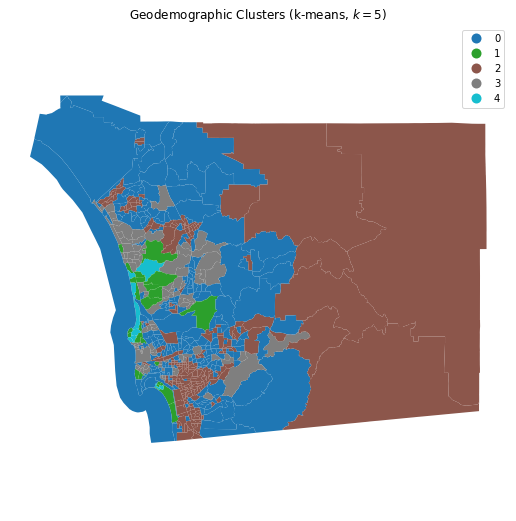

In [20]:
# Assign labels into a column
db['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=5$)')
# Display the map
plt.show()

We can see that a set of tracts with the same color emerge.

Our eyes are drawn to the larger polygons in the eastern part of the
county, giving the impression that cluster 2 is the dominant cluster. While this
seems to be true in terms of land area (and we will verify this below).

### Statistical Analysis of the Cluster Map

To complement the geovisualization of the clusters, we can explore the
statistical properties of the cluster map. This process allows us to delve
into what observations are part of each cluster and what their
characteristics are.

This gives us the profile of each cluster so we can interpret the meaning of the
labels we've obtained. We can start, for example, by
considering cardinality, or the count of observations in each cluster:

In [21]:
# Group data table by cluster label and count observations
k5sizes = db.groupby('k5cls').size()
k5sizes

k5cls
0    240
1     25
2    252
3    102
4      9
dtype: int64

And we can get a visual representation of cardinality as well:

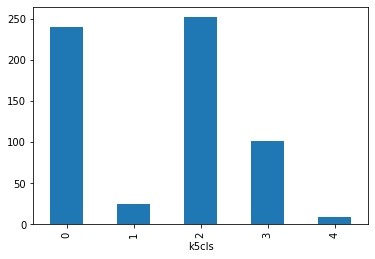

In [22]:
_ = k5sizes.plot.bar()

There are substantial differences in the sizes of the five clusters, with two very
large clusters (0, 3), one medium sized cluster (2), and two small clusters (1,
4). Cluster 3 is the largest when measured by the number of assigned tracts.
This confirms our intuition from the map above, where we got the visual impression
that tracts in cluster 3 seemed to have the largest area. Let's see if this is 
the case. To do so we can use the `dissolve` operation in `geopandas`, which 
combines all tracts belonging to each cluster into a single
polygon object. After we have dissolved all the members of the clusters,
we report the total land area of the cluster:

In [23]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
areas = db.dissolve(by='k5cls', aggfunc='sum')['area_sqm']
areas

k5cls
0    4137.818456
1     245.344545
2    6636.436568
3     639.170197
4      63.002873
Name: area_sqm, dtype: float64

And, to show this visually:

<AxesSubplot:xlabel='k5cls'>

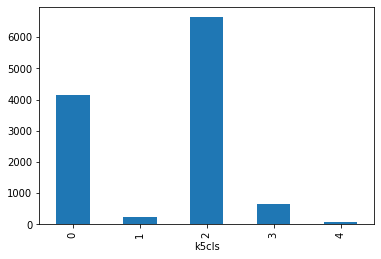

In [24]:
areas.plot.bar()

Our visual impression is confirmed: cluster 2 contains tracts that
together comprise 6,636 square kilometers (approximately 2562 square miles),
which accounts for over half of the total land area in the county:

In [25]:
areas[2]/areas.sum()

0.5661632222804679

Let's move on to build the profiles for each cluster. Again, the profiles is what
provides the conceptual shorthand, moving from the arbitrary label to a meaningful
collection of observations with similar attributes. To build a basic profile, we can
compute the means of each of the attributes in every cluster:

In [26]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = db.groupby('k5cls')[cluster_variables].mean()
k5means.T.round(3)

k5cls,0,1,2,3,4
median_house_value,500787.575,1168004.000,326728.968,736881.373,1876867.222
pct_white,0.722,0.841,0.658,0.805,0.909
pct_rented,0.406,0.288,0.512,0.325,0.251
pct_hh_female,0.102,0.107,0.106,0.104,0.117
pct_bachelor,0.010,0.002,0.020,0.004,0.002
median_no_rooms,5.294,6.020,4.627,5.733,6.422
income_gini,0.401,0.474,0.402,0.430,0.520
median_age,37.211,44.436,34.246,41.600,50.544
tt_work,2539.429,2182.000,2187.754,2336.284,1237.778


We see that cluster 4, for example, is composed of tracts that have
the highest average `median_house_value`, and also the highest level of inequality
(`income_gini`); and cluster 4 contains an older population (`median_age`)
who tend to live in housing units with more rooms (`median_no_rooms`).
Average values, however, can hide a great deal of detail and, in some cases,
give wrong impressions about the type of data distribution they represent. To
obtain more detailed profiles, we can use the `describe` command in `pandas`, 
after grouping our observations by their clusters:

In [27]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = db.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
                    count           mean           std         min  \
median_house_value  240.0  500787.574698  57295.975694  414100.000   
pct_white           240.0       0.722390      0.149383       0.000   
pct_rented          240.0       0.405979      0.223881       0.000   
pct_hh_female       240.0       0.101796      0.030586       0.000   
pct_bachelor        240.0       0.010111      0.010658       0.000   
median_no_rooms     240.0       5.294402      0.957028       2.800   
income_gini         240.0       0.400898      0.048220       0.283   
median_age          240.0      37.210522      7.389658      16.500   
tt_work             240.0    2539.429167   1911.989514       0.000   

                              25%            50%            75%            max  
median_house_value  453750.000000  496850.000000  539675.000000  617000.000000  
pct_white                0.667674       0.754861       0.823160       0.946018  
pct_rented               0.225816

However, this approach quickly gets out of hand: more detailed profiles can simply
return to an unwieldy mess of numbers. A better approach to constructing
cluster profiles is be to draw the distributions of cluster members' data.
To do this we need to "tidy up" the dataset. A tidy dataset ([Wickham,
2014](https://www.jstatsoft.org/article/view/v059i10)) is one where every row is
an observation, and every column is a variable. Thus, a few steps are required 
to tidy up our labelled data:

In [28]:
# Index db on cluster ID
tidy_db = db.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,2,median_house_value,371800.000000
1,2,pct_white,0.658598
2,2,pct_rented,0.524267
3,2,pct_hh_female,0.130259
4,2,pct_bachelor,0.011335


In [29]:
len(tidy_db)

5652

Now we are ready to plot. Below, we'll show the distribution of each cluster's values
for each variable. This gives us the full distributional profile of each cluster:

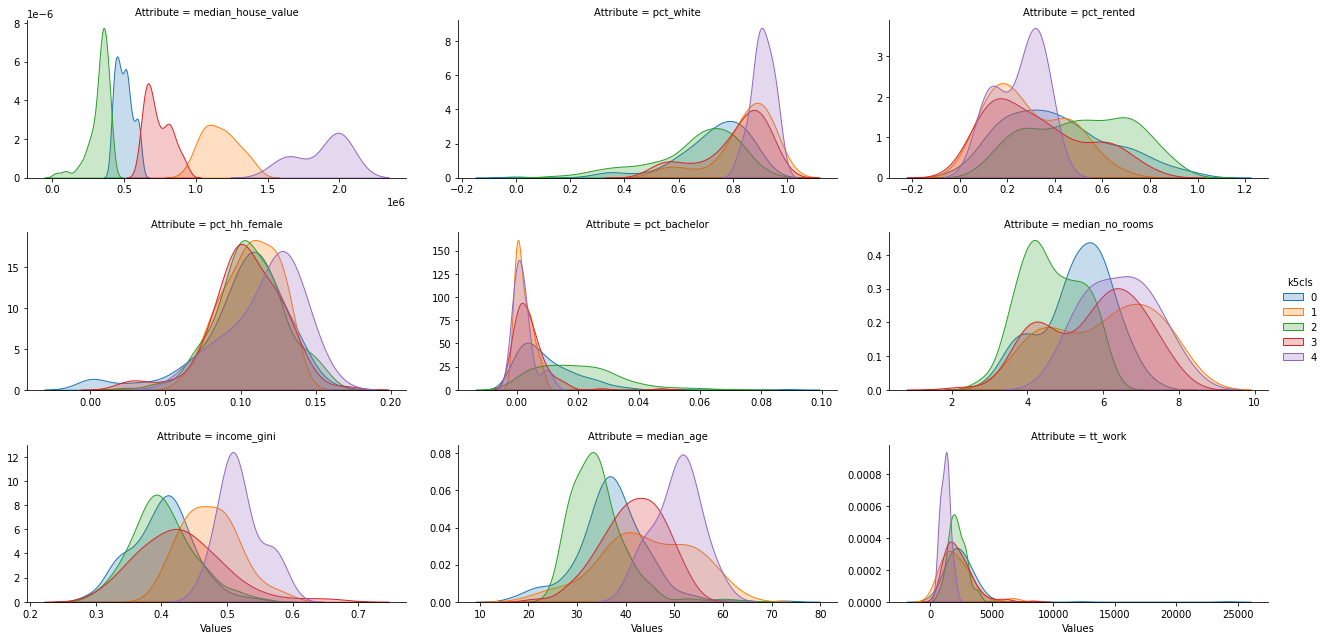

In [30]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

This allows us to see that, while some attributes such as the percentage of
female households (`pct_hh_female`) display largely the same distribution for
each cluster, others paint a much more divided picture (e.g. `median_house_value`).
Taken altogether, these graphs allow us to start delving into the multidimensional 
complexity of each cluster and the types of areas behind them.

## Clustering Algorithms
k-means is only one clustering algorithm. There are
plenty more. Agglomerative clustering works by building a hierarchy of
clustering solutions that starts with all singletons (each observation is a single
cluster in itself) and ends with all observations assigned to the same cluster.
These extremes are not very useful in themselves. But, in between, the hierarchy
contains many distinct clustering solutions with varying levels of detail. 
The intuition behind the algorithm is also rather straightforward: 

1) begin with everyone as part of its own cluster; 
2) find the two closest observations based on a distance metric (e.g. euclidean); 
3) join them into a new cluster; 
4) repeat steps 2) and 3) until reaching the degree of aggregation desired. 

The algorithm is thus called "agglomerative"
because it starts with individual clusters and "agglomerates" them into fewer
and fewer clusters containing more and more observations each. Also, like with 
k-means, AHC does require the user to specify a number of clusters in advance.
This is because, following from the mechanism the method has to build clusters, 
AHC can provide a solution with as many clusters as observations ($k=n$),
or with a only one ($k=1$).



In [31]:
# Set seed for reproducibility
numpy.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(db[cluster_variables])
# Assign labels to main data table
db['ward5'] =model.labels_

As above, we can check the number of observations that fall within each cluster:

In [32]:
ward5sizes = db.groupby('ward5').size()
ward5sizes

ward5
0    141
1    233
2    222
3     23
4      9
dtype: int64

Further, we can check the simple average profiles of our clusters:

In [33]:
ward5means = db.groupby('ward5')[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,703765.957,473097.931,316161.712,1184173.913,1876867.222
pct_white,0.799,0.706,0.656,0.842,0.909
pct_rented,0.327,0.420,0.523,0.293,0.251
pct_hh_female,0.105,0.102,0.106,0.107,0.117
pct_bachelor,0.005,0.011,0.021,0.002,0.002
median_no_rooms,5.695,5.222,4.575,5.939,6.422
income_gini,0.421,0.401,0.403,0.478,0.520
median_age,41.535,36.389,34.062,44.261,50.544
tt_work,2305.206,2556.399,2172.563,2201.913,1237.778


And again, we can create a plot of the profiles' distributions (after properly 
tidying up):

In [34]:
# Index db on cluster ID
tidy_db = db.set_index('ward5')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,2,median_house_value,371800.000000
1,2,pct_white,0.658598
2,2,pct_rented,0.524267
3,2,pct_hh_female,0.130259
4,2,pct_bachelor,0.011335


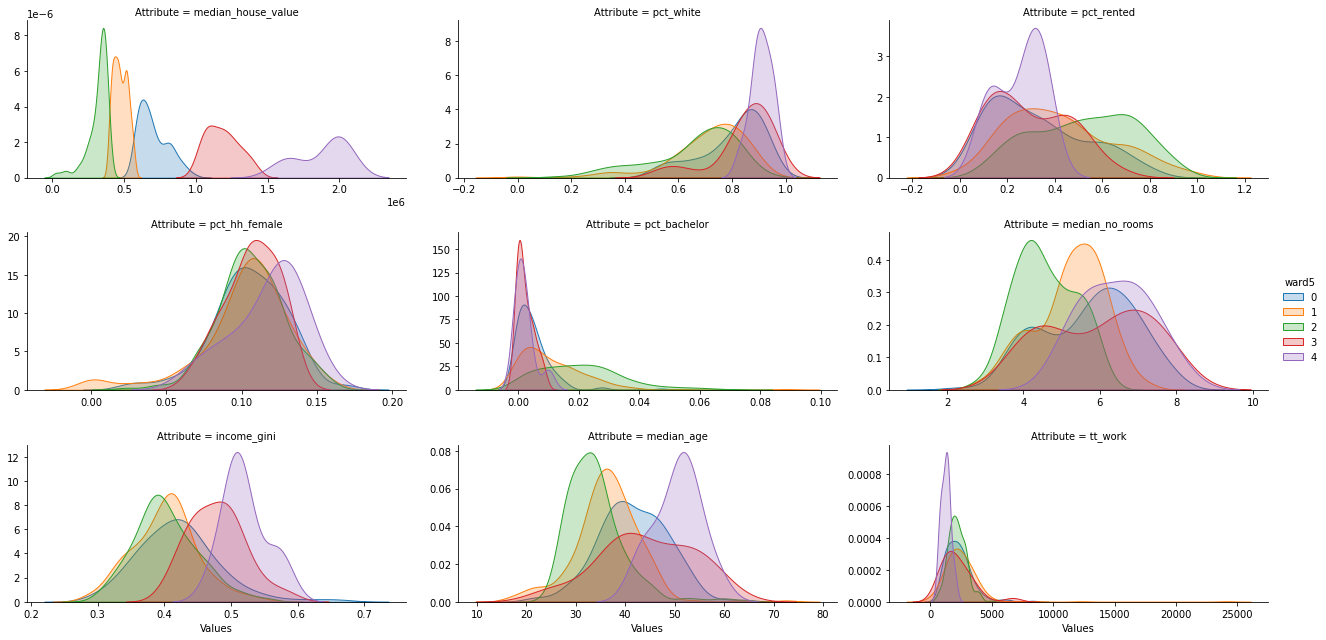

In [35]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

For the sake of brevity, we will not spend much time on the plots above.
However, the interpretation is analogous to that of the k-means example.

On the spatial side, we can explore the geographical dimension of the
clustering solution by making a map the clusters:

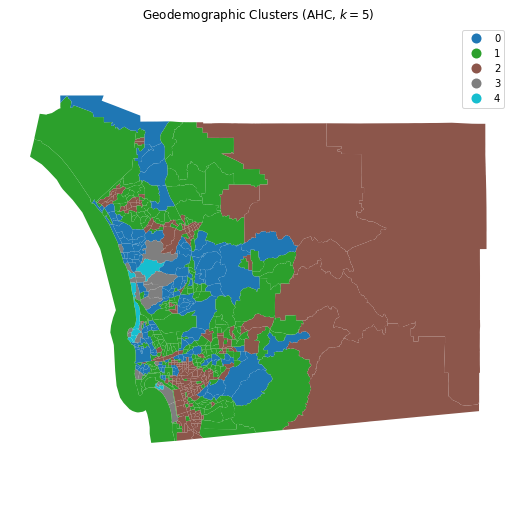

In [36]:
db['ward5'] =model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Clusters (AHC, $k=5$)')
# Display the map
plt.show()

And, to make comparisons simpler, we can display both the k-means and the AHC
results side by side:

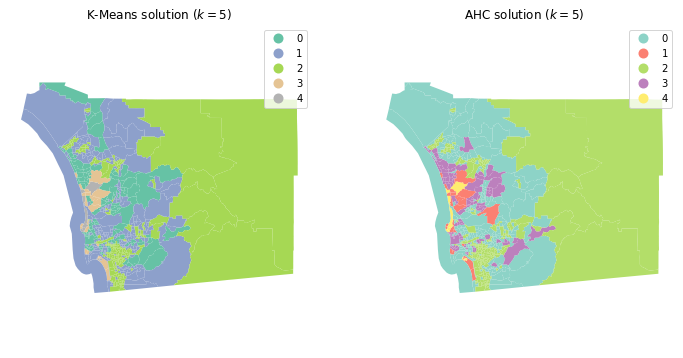

In [37]:
db['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, cmap='Set2', 
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('K-Means solution ($k=5$)')

ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, cmap='Set3',
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

While we must remember our earlier caveat about how irregular polygons can 
baffle our visual intuition, a closer visual inspection of the cluster geography
suggests a clear pattern: although they are not identical, both clusterings capture
very similar overall spatial structure. Furthermore, both solutions slightly violate 
Tobler's law, since all of the clusters have disconnected components. The five
multivariate clusters in each case are actually composed of many disparate 
geographical areas, strewn around the map according only to the structure of the
data and not its geography. That is, in order to travel to
every tract belonging to a cluster, we would have to journey through
other clusters as well.

Even though we have specified a spatial constraint, the constraint applies to the
connectivity graph modeled by our weights matrix. Therefore, using k-nearest neighbors
to constrain the agglomerative clustering may not result in regions that are connected
according to a different connectivity rule, such as the queen contiguity rule used
in the previous section. However, the regionalization here is fortuitous; even though
we used the 4-nearest tracts to constrain connectivity, all but one of the clusters, 
cluster 4, is *also* connected according to our earlier queen contiguity rule. 

At first glance, this may seem counter-intuitive. We did specify the spatial
constraint, so our initial reaction is that the connectivity constraint is
violated. However, this is not the case, since the constraint applies to the
k-nearest neighbor graph, not the queen contiguity graph. Therefore, since tracts
in this solution are considered as connected to their four closest neighbors,
clusters can "leapfrog" over one another. Thus, it is important to recognize that
the apparent spatial structure of regionalizations will depend on how the 
connectivity of observations is modeled. 

## Conclusion

Thus, clustering reduces this complexity into a single conceptual shorthand by which 
people can easily describe complex and multifaceted data. 
Clustering constructs groups of observations (called *clusters*)
with coherent *profiles*, or distinct and internally-consistent 
distributional/descriptive characteristics. 
These profiles are the conceptual shorthand, since members of each cluster should
be more similar to the cluster at large than they are to any other cluster. 
Many different clustering methods exist; they differ on how the "cluster at large" 
is defined, and how "similar" members must be to clusters, or how these clusters
are obtained.

# Note next class we see how to select K and 